In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree


In [3]:
merged_df = pd.read_csv('./data/WATER_METADATA_PHYTOPLANKTON.csv')

/tmp/ipykernel_14539/1171552593.py:1: DtypeWarning: Columns (23,24,33,35,39,40,41,42,43,44,45,46,47,48,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('./data/WATER_METADATA_PHYTOPLANKTON.csv')


In [4]:
var_list = ['Temperature', 'pH', 'Dissolved oxygen', 'Oxygen saturation %', 'Salinity', 
            'Secchi disk', 'Suspended solids', 'Silicate', 'Nitrite', 'Ammonium',
            'Turbidity', 'Nitrate', 'Ortophosphate', 'Physico-Chemical Quality Index', 
            'minimumdepthinmeters', 'maximumdepthinmeters', ]

# Trying XGBoost

In [27]:
sample = merged_df[merged_df['taxaname'] == 'Plagioselmis'].reset_index(drop=True)
sample.head()

,siteid,sitename,country,seaname,decimallatitude,decimallongitude,datecollected,Temperature,pH,Dissolved oxygen,...,sampleid,basisofrecord,minimumdepthinmeters,maximumdepthinmeters,taxaname,taxanameid,samplingeffort,parameter,parameter_value,parameter_standardunit
0,E-A10HS,Ondarroa (Embarcadero). High Tide. Surface,ES,Bay of Biscay,43.319883,-2.420973,24/04/2002,16.5,8.34,8.2940,...,E-A10_20020424,MaterialSample,0,0.5,Plagioselmis,106283,125 ml,Abundance,4.200,cel/ml
1,E-A10HS,Ondarroa (Embarcadero). High Tide. Surface,ES,Bay of Biscay,43.319883,-2.420973,04/09/2002,18.3,8.09,7.0642,...,E-A10_20020904,MaterialSample,0,0.5,Plagioselmis,106283,125 ml,Abundance,8.496,cel/ml
2,E-A10HS,Ondarroa (Embarcadero). High Tide. Surface,ES,Bay of Biscay,43.319883,-2.420973,03/09/2003,21.7,8.18,4.2185,...,E-A10_20030903,MaterialSample,0,0.5,Plagioselmis,106283,125 ml,Abundance,76.464,cel/ml
3,E-A10HS,Ondarroa (Embarcadero). High Tide. Surface,ES,Bay of Biscay,43.319883,-2.420973,11/08/2005,21.6,7.92,4.6618,...,E-A10_20050811,MaterialSample,0,0.5,Plagioselmis,106283,125 ml,Abundance,42.480,cel/ml
4,E-A10HS,Ondarroa (Embarcadero). High Tide. Surface,ES,Bay of Biscay,43.319883,-2.420973,30/08/2006,21.6,7.96,4.7905,...,E-A10_20060830,MaterialSample,0,0.5,Plagioselmis,106283,125 ml,Abundance,111.510,cel/ml


In [37]:
sample[var_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature                     1977 non-null   float64
 1   pH                              1951 non-null   float64
 2   Dissolved oxygen                1976 non-null   float64
 3   Oxygen saturation %             1976 non-null   float64
 4   Salinity                        1977 non-null   float64
 5   Secchi disk                     1973 non-null   object 
 6   Suspended solids                1977 non-null   object 
 7   Silicate                        1977 non-null   object 
 8   Nitrite                         1977 non-null   object 
 9   Ammonium                        1977 non-null   object 
 10  Turbidity                       1977 non-null   float64
 11  Nitrate                         1977 non-null   object 
 12  Ortophosphate                   19

In [ ]:
var_list_s = ['Temperature', 'pH', 'Dissolved oxygen', 'Oxygen saturation %', 'Salinity', 'Turbidity', 'Physico-Chemical Quality Index', 
            'minimumdepthinmeters', 'maximumdepthinmeters', ]



In [38]:
for var in var_list:
    sample[var] = pd.to_numeric(sample[var], errors='coerce').fillna(0)


In [39]:
sample['Secchi disk'].mean()

np.float64(5.826710261569416)

In [40]:
sample[var_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Temperature                     1988 non-null   float64
 1   pH                              1988 non-null   float64
 2   Dissolved oxygen                1988 non-null   float64
 3   Oxygen saturation %             1988 non-null   float64
 4   Salinity                        1988 non-null   float64
 5   Secchi disk                     1988 non-null   float64
 6   Suspended solids                1988 non-null   float64
 7   Silicate                        1988 non-null   float64
 8   Nitrite                         1988 non-null   float64
 9   Ammonium                        1988 non-null   float64
 10  Turbidity                       1988 non-null   float64
 11  Nitrate                         1988 non-null   float64
 12  Ortophosphate                   19

Mean Squared Error: 143449.6935
R² Score: 0.0018


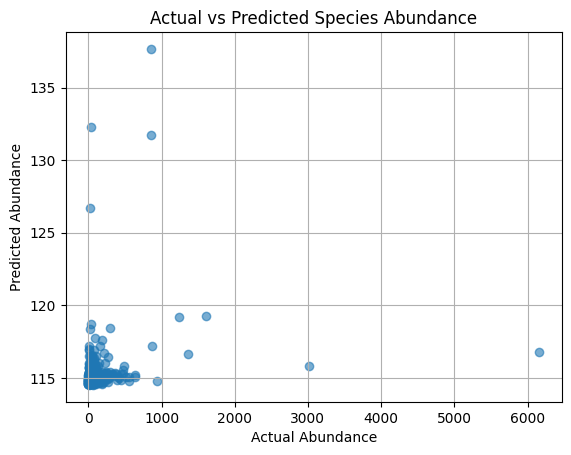

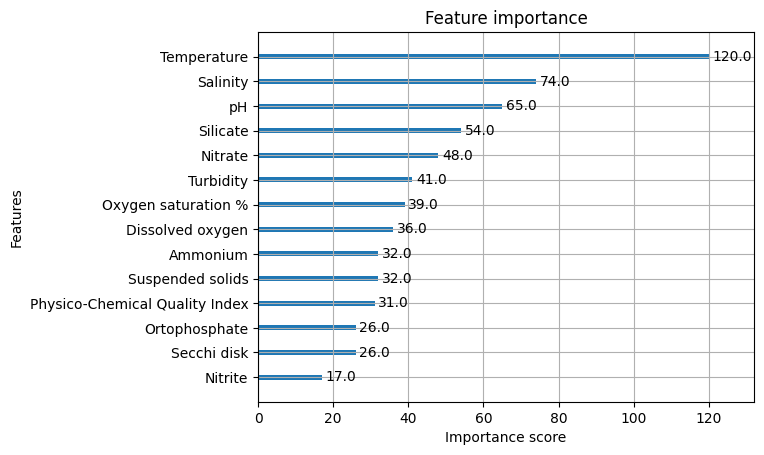

In [43]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# trying out for site EA10HS
all_cov = var_list + ["parameter_value", "datecollected"]
df = sample[all_cov].dropna()

df = df.sort_values(by="datecollected")

# splitting into train and test data  
split_point = int(len(df) * 0.8)  # 80% train, 20% test

train = df.iloc[:split_point]
test = df.iloc[split_point:]

# Select Features and Target Variable
X_train = train[var_list]
y_train = train["parameter_value"] # parameter_value = abundance
X_test = test[var_list]
y_test = test["parameter_value"]

# Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost Model
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.001,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

model = xgb.train(params, dtrain, num_boost_round=10)

# Make Predictions
y_pred = model.predict(dtest)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Actual vs. Predicted Values
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Abundance")
plt.ylabel("Predicted Abundance")
plt.title("Actual vs Predicted Species Abundance")
plt.grid(True)
plt.show()

# Feature Importance Plot
xgb.plot_importance(model)
plt.show()
